In [ ]:
# Importing libraries for preprocessing, plots and stats
import requests
import torchvision.transforms as tf
from PIL import Image
from io import BytesIO
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import numpy as np
import math

## Convolution Layer

In [ ]:
class ConvLayer:

    def __init__(self, inp_dim, kernel_size, kernels_num):
        self.inp_ch, inp_ht, inp_wd = inp_dim
        self.kernels_num = kernels_num
        self.inp_dim = inp_dim

        # Kernel and Biases initialization
        self.kernel_dim = (kernels_num, self.inp_ch, kernel_size, kernel_size)
        self.out_dim = (kernels_num, self.inp_ch, inp_ht - kernel_size + 1, inp_wd - kernel_size + 1)
        self.kernels = np.random.randn(*self.kernel_dim)


    def crossCorrelate(self,inp_matrix, kernel):
        # Get the dimensions of the input matrix and the kernel
        inp_ht, inp_wd = inp_matrix.shape
        kernel_ht, kernel_wd = kernel.shape

        out_ht = inp_ht - kernel_ht + 1
        out_wd = inp_wd - kernel_wd + 1

        # Initialize the output matrix with zeros
        out = np.zeros((out_ht, out_wd))

        # Perform the 2D cross-correlation
        for h in range(out_ht):
            for w in range(out_wd):
                out[h, w] = np.sum(inp_matrix[h : h + kernel_ht, w : w + kernel_wd] * kernel)

        return out

    def forward_prop(self, inp):
        # conv layer input image initialization
        self.inp = inp

        # conv layer output initialization
        conv_out = np.zeros(self.out_dim)

        # cross correlation by iteration
        for k in range(self.kernels_num):
            for ch in range(self.inp_ch):
              conv_out[k, ch] = self.crossCorrelate(self.inp[ch], self.kernels[k, ch])

        # RELU Activation
        conv_out = np.maximum(conv_out, 0)

        return conv_out

    def back_prop(self, conv_out_grad, alpha):
        kernels_grad = np.zeros_like(self.kernels)

        for k in range(self.kernels_num):
                for ch in range(self.inp_ch):
                  # loss gradient w.r.t kernels
                  kernels_grad[k, ch] = self.crossCorrelate(self.inp[ch], conv_out_grad[k, ch])

        # Kernel Update (SGD)
        self.kernels -= alpha * kernels_grad


## Max Pool Layer

In [ ]:
class MaxPoolingLayer:

    def __init__(self, fil_size):
        self.fil_size = fil_size

    def forward_prop(self, inp):

        self.inp = inp
        self.num_ch, self.num_color_ch, self.inp_ht, self.inp_wd = inp.shape
        self.out_ht = self.inp_ht // self.fil_size
        self.out_wd = self.inp_wd // self.fil_size

        # Computing output shape based on input size and pooling filter size
        self.max_pool_out = np.zeros((self.num_ch, self.num_color_ch, self.out_ht, self.out_wd))

        # Looping through feature maps produced by convolution
        for ch in range(self.num_ch):
            # Looping through the RGB colored feature maps
            for color in range(self.num_color_ch):
              # Traversing the height of input map
              for h in range(self.out_ht):
                  # Traversing the width of input map
                  for w in range(self.out_wd):

                      # pool window start point
                      s_h = h * self.fil_size
                      s_w = w * self.fil_size

                      # pool window end point
                      e_h = s_h + self.fil_size
                      e_w = s_w + self.fil_size

                      # Creating a window from the input data
                      window = inp[ch, color, s_h:e_h, s_w:e_w]

                      # Picking the max value from each window
                      self.max_pool_out[ch, color, h, w] = np.max(window)

        return self.max_pool_out

    def back_prop(self, pool_out_grad):
        pool_inp_grad = np.zeros_like(self.inp)

        for ch in range(self.num_ch):
          for color in range(self.num_color_ch):
            for h in range(self.out_ht):
              for w in range(self.out_wd):
                s_h = h * self.fil_size
                s_w = w * self.fil_size

                e_h = s_h + self.fil_size
                e_w = s_w + self.fil_size
                window = self.inp[ch, color, s_h:e_h, s_w:e_w]

                mask = window == np.max(window)

                pool_inp_grad[ch, color, s_h:e_h, s_w:e_w] = pool_out_grad[ch, color, h, w] * mask

        return pool_inp_grad

## Dense Layer / Fully Connected Layer (with Flattening and ReLu)

In [ ]:
class FlattenAndDenseLayer:

    def __init__(self, inp_dim, out_dim):
        self.inp_dim = inp_dim # Length of flattened 1d array
        self.out_dim = out_dim # Num of neurons in next layer
        self.W = np.random.randn(out_dim, self.inp_dim)
        self.B = np.random.rand(out_dim, 1)


    def forward_prop(self, inp):
        self.inp = inp
        # Multiple channels input img matrix flattened to 1D
        flat_array = inp.flatten().reshape(1, -1)
        # Z = W.X + B
        self.linear_out = np.dot(self.W, flat_array.T) + self.B

        # RELU Activation
        self.dense_out = np.maximum(self.linear_out, 0)
        return self.dense_out

    # RELU derivative or RELU Inverse
    def relu_der(self, data):
        relu_der = np.maximum(0, data)
        relu_der[relu_der > 0] = 1
        return relu_der

    def back_prop(self, dense_out_grad, alpha):
        # Computing dL/dZ
        Z_grad = self.relu_der(self.linear_out) * dense_out_grad
        # Computing dL/dW
        weights_grad = np.dot(Z_grad, self.inp.flatten().reshape(1, -1))

        # Computing dL/dB
        biases_grad = Z_grad

        # Computing dL/d(dense_layer_input)
        dense_inp_grad = np.dot(self.W.T, Z_grad)
        dense_inp_grad = dense_inp_grad.reshape(self.inp.shape)

        # Weight and Bias Update (SGD)
        self.W -= alpha * weights_grad
        self.B -= alpha * biases_grad

        # dL/d(dense_layer_input) is returned
        return dense_inp_grad

## Dense Layer / Fully Connected Layer (with Softmax)

In [ ]:
class FinalFCLayer:

    def __init__(self, inp_dim, out_dim):
        self.inp_dim = inp_dim # Num of neurons in this layer
        self.out_dim = out_dim # Num of output classes
        self.W = np.random.randn(out_dim, self.inp_dim)
        self.B = np.random.rand(out_dim, 1)

    def activation_softmax(self, data):
        # Input values are shifted for numerical stability
        inp_shifted = data - np.max(data)
        e_vals = np.exp(inp_shifted)
        sum_of_e_vals = np.sum(e_vals, axis=0)

        # Class probabilities
        softmax_class_probs = e_vals / sum_of_e_vals

        return softmax_class_probs

    # Softmax derivative or Softmax Inverse
    def der_softmax(self, predicted, actual):
        return predicted - actual.reshape(3,1)

    def forward_prop(self, inp):
        self.inp = inp
        self.linear_out = np.dot(self.W, inp) + self.B

        # Softmax Activation
        self.fc_out = self.activation_softmax(self.linear_out)
        return self.fc_out

    def back_prop(self, fc_out_grad, true, alpha):
        # Computing dL/dZ
        Z_grad = self.der_softmax(self.fc_out, true)
        # Computing dL/dW
        weights_grad = np.dot(Z_grad, self.inp.T)
        # Computing dL/dB
        biases_grad = Z_grad

        # Computing dL/d(FC_layer_input)
        fc_inp_grad = np.dot(self.W.T, Z_grad)

        # Weights and Biases Update (SGD)
        self.W -= alpha * weights_grad
        self.B -= alpha * biases_grad

        # dL/d(FC_layer_input) is returned
        return fc_inp_grad

# CNN MODEL

In [ ]:
class CnnModel:
    def __init__(self, inp_dim, fil_size, num_filters, pool_size, neurons, out_classes):
        self.convolve = ConvLayer(inp_dim, fil_size, num_filters)
        self.max_pooling = MaxPoolingLayer(pool_size)
        self.dense = FlattenAndDenseLayer(int((math.pow(((inp_dim[1] - fil_size + 1)//2),2)) * 3), neurons)
        self.fully_conn = FinalFCLayer(neurons, out_classes)

    def loss_cross_entropy(self, predicted, true):
        classes = 3
        # Small epsilon value added to avoid log(0)
        eps = 1e-7
        predicted = np.clip(predicted, eps, 1 - eps)
        error = -np.sum(true * np.log(predicted)) / classes
        return error


    def grad_loss_cross_entropy(self, true, pred):
        classes = true.shape[0]
        loss_grad = -true / (pred + 1e-7) / classes
        return loss_grad

    def train(self, x, Y, alpha, epochs, batch_size):
        self.cost_curve = []
        self.acc_curve = []
        for epoch in range(epochs):
            random_batch = np.random.choice(x.shape[0], batch_size, replace=False)
            trainX = x[random_batch]
            trainY = Y[random_batch]
            loss_sum = 0.0
            acc_score = 0

            for img in range(len(trainX)):
                # Steps for forward propagation
                conv_layer_output = self.convolve.forward_prop(trainX[img])
                pool_layer_output = self.max_pooling.forward_prop(conv_layer_output)
                dense_layer_output = self.dense.forward_prop(pool_layer_output)
                fc_layer_output = self.fully_conn.forward_prop(dense_layer_output)
                loss = self.loss_cross_entropy(fc_layer_output.flatten(), trainY[img])
                loss_sum += loss

                # Accuracy computation with one hot encoded prediction
                prediction_one_hot = np.zeros_like(fc_layer_output)
                prediction_one_hot[np.argmax(fc_layer_output)] = 1
                prediction_one_hot = prediction_one_hot.flatten()
                pred_index = np.argmax(prediction_one_hot)
                actual_index = np.argmax(trainY[img])
                if pred_index == actual_index:
                    acc_score += 1

                # Steps for backward propagation
                gradient = self.grad_loss_cross_entropy(trainY[img], fc_layer_output.flatten()).reshape((-1, 1))
                dl_dFC = self.fully_conn.back_prop(gradient, trainY[img], alpha)
                dl_dDense = self.dense.back_prop(dl_dFC, alpha)
                pool_grad = self.max_pooling.back_prop(dl_dDense)
                self.convolve.back_prop(pool_grad, alpha)


            # Summary of current epoch (average loss and average accuracy)
            epoch_loss = loss_sum / len(trainX)
            epoch_acc = acc_score / len(trainX) * 100.0
            self.cost_curve.append(epoch_loss)
            self.acc_curve.append(epoch_acc/100.0)
            print("Epoch ",epoch + 1,"/",epochs," - Loss: ",round(epoch_loss,4)," - Accuracy: ",round(epoch_acc,2),"%")


    def plot_training_curves(self):
        # Cost vs Epochs plot
        plt.subplot(2, 1, 1)
        plt.plot(self.cost_curve, color='red', label='Cost')
        plt.xlabel('Epochs')
        plt.ylabel('Cost')
        plt.title('Cost Over Epochs')

        # Accuracy vs epochs plot
        plt.subplot(2, 1, 2)
        plt.plot(self.acc_curve, color='green', label='Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Accuracy Over Epochs')

        # display
        plt.tight_layout()
        plt.show()

    def predict_img(self, img):
        conv_layer_output = self.convolve.forward_prop(img)
        pool_layer_output = self.max_pooling.forward_prop(conv_layer_output)
        dense_layer_output = self.dense.forward_prop(pool_layer_output)
        pred = self.fully_conn.forward_prop(dense_layer_output)

        return pred

    def get_stats(self, data, true_labels):
        predicted_labels = []
        total_loss = 0

        for img in range(len(data)):
            prediction = self.predict_img(data[img])
            loss = self.loss_cross_entropy(prediction.flatten(), true_labels[img])
            total_loss += loss
            pred_one_hot = np.zeros_like(prediction)
            pred_one_hot[np.argmax(prediction)] = 1
            predicted_labels.append(pred_one_hot.flatten())

        predicted_labels = np.array(predicted_labels)
        accuracy = accuracy_score(predicted_labels, true_labels)
        total_loss = total_loss/len(data)

        return accuracy, total_loss


# Data Loading and Preprocessing

In [ ]:
# Method to load each image
def load_image_from_git(url):
  response = requests.get(url)

  # load image in RGB mode
  image = Image.open(BytesIO(response.content)).convert('RGB')

  # set up transformation to resize the image
  size_change = tf.Resize([28, 28])
  image = size_change(image)
  tensor_convert = tf.ToTensor()

  # apply transformation and convert to Pytorch tensor
  tensor = tensor_convert(image)

  return np.array(tensor)

In [ ]:
# Method to load all images and labels
def getData(data):
    if data == 'train':
      img_len = 1000
    else:
      img_len = 200
    tensors = []
    lbls = []
    all_picture_types = ['b', 'f', 'm']
    for i in range(len(all_picture_types)):
        for j in range(img_len):
          url_ = 'https://raw.githubusercontent.com/s1s1ra/CNN-for-Scene-Recognition/main/'+data+'/'+all_picture_types[i]+str(j)+'.jpg'
          img = load_image_from_git(url_)
          tensors.append(img)
          lbls.append(i)

    return np.array(tensors), np.array(lbls)

In [ ]:
# Retrieving training and testing datasets
X_train, train_labels = getData('train')
X_test, test_labels = getData('test')

In [ ]:
# One-hot or binary encoding of true class labels
y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

y_test[0]

array([1., 0., 0.], dtype=float32)

In [ ]:
# Shuffling the data
shuffled_indices = np.random.permutation(X_train.shape[0])
X_train_shuffled = X_train[shuffled_indices]
y_train_shuffled = y_train[shuffled_indices]

shuffled_indices = np.random.permutation(X_test.shape[0])
X_test_shuffled = X_test[shuffled_indices]
y_test_shuffled = y_test[shuffled_indices]

In [ ]:
# Renaming to conventional variable names
X_train, y_train, X_test, y_test = X_train_shuffled, y_train_shuffled, X_test_shuffled, y_test_shuffled

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3000, 3, 28, 28)
(3000, 3)
(600, 3, 28, 28)
(600, 3)


# Model Training and Testing

In [ ]:
# Input and output dimensions
img_dimension = X_train[0].shape
num_output_classes = 3

# Hyperparameters
filter_size = 6
num_filters = 1
pool_window_size = 2
dense_neurons = 95
learning_rate = 0.00025
epochs = 200
batch_size = 750

# Model Creation and Training
model = CnnModel(img_dimension, filter_size, num_filters, pool_window_size, dense_neurons, num_output_classes)
model.train(X_train, y_train, learning_rate, epochs, batch_size)

Epoch  1 / 200  - Loss:  2.8931  - Accuracy:  42.13 %
Epoch  2 / 200  - Loss:  2.5966  - Accuracy:  46.8 %
Epoch  3 / 200  - Loss:  2.3347  - Accuracy:  48.8 %
Epoch  4 / 200  - Loss:  2.073  - Accuracy:  54.8 %
Epoch  5 / 200  - Loss:  2.0101  - Accuracy:  51.73 %
Epoch  6 / 200  - Loss:  1.9072  - Accuracy:  52.67 %
Epoch  7 / 200  - Loss:  1.9096  - Accuracy:  49.33 %
Epoch  8 / 200  - Loss:  1.7374  - Accuracy:  54.53 %
Epoch  9 / 200  - Loss:  1.5368  - Accuracy:  55.33 %
Epoch  10 / 200  - Loss:  1.4785  - Accuracy:  55.07 %
Epoch  11 / 200  - Loss:  1.3643  - Accuracy:  54.13 %
Epoch  12 / 200  - Loss:  1.2888  - Accuracy:  57.33 %
Epoch  13 / 200  - Loss:  1.2736  - Accuracy:  57.33 %
Epoch  14 / 200  - Loss:  1.228  - Accuracy:  56.53 %
Epoch  15 / 200  - Loss:  1.2722  - Accuracy:  56.93 %
Epoch  16 / 200  - Loss:  1.0116  - Accuracy:  60.0 %
Epoch  17 / 200  - Loss:  1.0857  - Accuracy:  56.93 %
Epoch  18 / 200  - Loss:  1.008  - Accuracy:  59.33 %
Epoch  19 / 200  - Loss:  

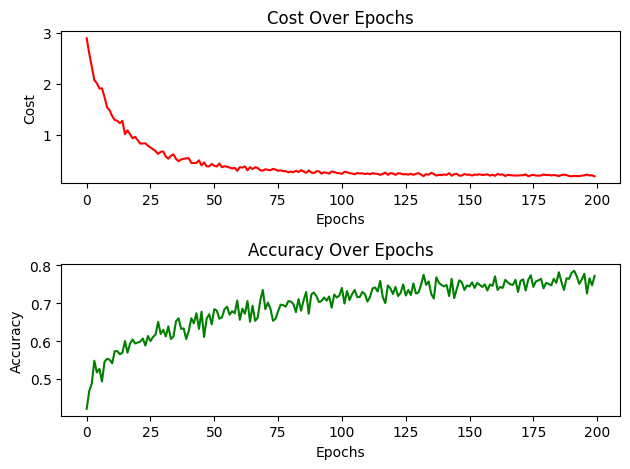

In [ ]:
# Training Plots
model.plot_training_curves()

### Training scores

In [ ]:
train_acc, train_loss = model.get_stats(X_train,y_train)

In [ ]:
print("Accuracy: ",round(train_acc,4)*100,"%  Loss",round(train_loss,3))

Accuracy:  79.83 %  Loss 0.171


### Testing scores

In [ ]:
test_acc, test_loss = model.get_stats(X_test,y_test)

In [ ]:
print("Accuracy: ",round(test_acc,4)*100,"%  Loss",round(test_loss,3))

Accuracy:  75.33 %  Loss 0.236


# #############################################################

# Some sample images

prediction: 2, actual: 2, prediction probability: 0.68


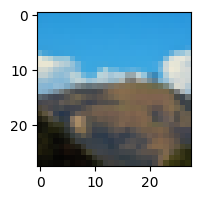

prediction: 1, actual: 1, prediction probability: 0.88


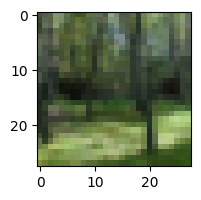

prediction: 0, actual: 0, prediction probability: 0.92


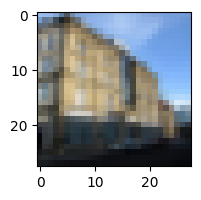

In [ ]:
sample_indices = np.array([9, 23, 39])

for i in sample_indices:
  pred = model.predict_img(X_test[i])
  print(f'prediction: {np.argmax(pred)}, actual: {np.argmax(y_test[i])}, prediction probability: {round(np.max(pred), 2)}')
  plt.imshow(np.transpose(X_test[i], (1, 2, 0)))
  figure = plt.gcf()
  figure.set_size_inches(2, 2)
  plt.show()